In [1]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import pathlib
import io
from datetime import datetime
import json
import xml.etree.ElementTree as ET, shutil
import os
import cv2
import time
import random
from PIL import Image
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D,
                                     Conv2D, MaxPool2D, Add, Dense,
                                     Flatten, InputLayer,
                                     BatchNormalization, Rescaling,
                                     Resizing, Input, Dropout,
                                     RandomFlip, RandomContrast,
                                     Rescaling, RandomRotation, Rescaling, Resizing)
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy, TopKCategoricalAccuracy, CategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping,
                                        LearningRateScheduler, ModelCheckpoint, 
                                        ReduceLROnPlateau)
from tensorflow.keras.regularizers import L1, L2
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature

In [ ]:
!kaggel datasets download -d huanghanchina/pascal-voc-2012

In [3]:
val_list = ['2007_000027.jpg', '2007_000032.jpg', '2007_000033.jpg', '2007_000039.jpg', '2007_000042.jpg', '2007_000061.jpg', 
           '2007_000063.jpg', '2007_000068.jpg', '2007_000121.jpg', '2007_000123.jpg', '2007_000129.jpg', '2007_000170.jpg', 
           '2007_000175.jpg', '2007_000187.jpg', '2007_000241.jpg', '2007_000243.jpg', '2007_000250.jpg', '2007_000256.jpg',  
           '2007_000272.jpg', '2007_000323.jpg', '2007_000332.jpg', '2007_000333.jpg', '2007_000346.jpg', '2007_000363.jpg', 
           '2007_000364.jpg', '2007_000392.jpg', '2007_000423.jpg', '2007_000452.jpg', '2007_000464.jpg', '2007_000480.jpg',  
           '2007_000491.jpg', '2007_000504.jpg', '2007_000515.jpg', '2007_000528.jpg', '2007_000529.jpg', '2007_000549.jpg',  
           '2007_000559.jpg', '2007_000572.jpg', '2007_000584.jpg', '2007_000629.jpg', '2007_000636.jpg', '2007_000645.jpg', 
           '2007_000648.jpg', '2007_000661.jpg', '2007_000663.jpg', '2007_000664.jpg', '2007_000676.jpg', '2007_000713.jpg', 
           '2007_000720.jpg', '2007_000727.jpg', '2007_000733.jpg', '2007_000738.jpg', '2007_000762.jpg', '2007_000768.jpg', 
           '2007_000783.jpg', '2007_000793.jpg', '2007_000799.jpg', '2007_000804.jpg', '2007_000807.jpg', '2007_000822.jpg', 
           '2007_001299.jpg', '2007_001311.jpg', '2007_001321.jpg', '2007_001340.jpg']

In [1]:
train_images = r"E:/python/segmentation/DRIVE/Data/VOC2012/JPEGImages/"
train_maps = r"E:/python/segmentation/DRIVE/Data/VOC2012/Annotations/"

val_images = r"E:/python/segmentation/DRIVE/Data/VOC2012/ValJPEGImages/"
val_maps = r"E:/python/segmentation/DRIVE/Data/VOC2012/ValAnnotations/"

classes = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
          "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]

B = 2
N_CLASSES = len(classes)
OBJ_INO = N_CLASSES + 5*B
H, W = 224, 224
SPLIT_SIZE = H // 32
N_EPOCHS = 135
BATCH_SIZE = 32

In [4]:
for name in val_list:
    shutil.move(train_maps + name[:-3] + "xml", val_maps + name[:-3] + "xml")

FileNotFoundError: [Errno 2] No such file or directory: 'E:/python/segmentation/DRIVE/Data/VOC2012/Annotations/2007_000027.xml'

In [ ]:
for name in val_list:
    shutil.move(train_images + name, val_images + name)

In [5]:
def preprocess_xml(filename):
    tree = ET.parse(filename)
    root = tree.getroot()
    size_tree = root.find('size')
    height = float(size_tree.find('height').text)
    width = float(size_tree.find('width').text)
    
    bounding_boxes = []
    
    for object_tree in root.findall('object'):
        for bounding_box in object_tree.iter("bndbox"):
            xmin = (float(bounding_box.find('xmin').text))
            ymin = (float(bounding_box.find('ymin').text))
            xmax = (float(bounding_box.find('xmax').text))
            ymax = (float(bounding_box.find('ymax').text))
            
            break
        class_name = object_tree.find('name').text
        class_dict = {classes[i]:i for i in range(len(classes))}
        bounding_box = [
            (xmin + xmax)/(2*width), (ymin + ymax)/(2*height), (xmax - xmin)/width,
            (ymax - ymin)/height, class_dict[class_name]
        ]
        bounding_boxes.append(bounding_box)
    
    return bounding_boxes

In [6]:
preprocess_xml(train_maps + "2007_000999.xml")

[[0.696, 0.722, 0.14933333333333335, 0.176, 4],
 [0.376, 0.516, 0.7413333333333333, 0.968, 14]]

In [7]:
def generate_output(bounding_boxes):
    output_label = np.zeros((SPLIT_SIZE, SPLIT_SIZE, N_CLASSES+5))
    
    for b in range(len(bounding_boxes)):
        grid_x = bounding_boxes[b][0]*SPLIT_SIZE
        grid_y = bounding_boxes[b][1]*SPLIT_SIZE
        i = int(grid_x)
        j = int(grid_y)
        

        output_label[i, j, 0:5] = ([1., grid_x%1, grid_y%1, bounding_boxes[b][2], bounding_boxes[b][3]])
        output_label[i, j, 5+int(bounding_boxes[b][4])] = (1.)
    return tf.convert_to_tensor(output_label, tf.float32)

In [8]:
generate_output(preprocess_xml(val_maps + "2007_000032.xml"))[3][3]

<tf.Tensor: shape=(25,), dtype=float32, numpy=
array([1.        , 0.353     , 0.2508897 , 0.542     , 0.37366548,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ],
      dtype=float32)>

In [9]:
im_paths = []
xml_paths = []

val_im_paths = []
val_xml_paths = []

for i in os.listdir(train_maps):
    
    im_paths.append(train_images + i[:-3] + "jpg")
    xml_paths.append(train_maps + i)
    
for i in os.listdir(val_maps):
    val_im_paths.append(val_images + i[:-3] + 'jpg')
    val_xml_paths.append(val_maps + i)
    
print(len(im_paths), len(xml_paths))
print(len(val_im_paths), len(val_xml_paths))

17061 17061
64 64


In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((im_paths, xml_paths))
val_dataset = tf.data.Dataset.from_tensor_slices((val_im_paths, val_xml_paths))

In [11]:
for i in val_dataset.take(1):
    print(i)

(<tf.Tensor: shape=(), dtype=string, numpy=b'E:/python/segmentation/DRIVE/Data/VOC2012/ValJPEGImages/2007_000027.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'E:/python/segmentation/DRIVE/Data/VOC2012/ValAnnotations/2007_000027.xml'>)


In [12]:
def get_imbboxes(im_path, xml_path):
    img = tf.io.decode_jpeg(tf.io.read_file(im_path))
    img = tf.cast(tf.image.resize(img, size=[H, W]), dtype=tf.float32)
    
    bboxes = tf.numpy_function(func=preprocess_xml, inp=[xml_path], Tout = tf.float32)
    return img,bboxes

In [13]:
train_dataset = train_dataset.map(get_imbboxes)
val_dataset = val_dataset.map(get_imbboxes)

In [14]:
classes[10]

'diningtabel'

In [15]:
def preprocess(img, bboxes):
    labels = tf.numpy_function(func=generate_output, inp=[bboxes], Tout=tf.float32)
    return img, labels

In [16]:
train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)

In [17]:
train_dataset = (
    train_dataset.
    batch(BATCH_SIZE).
    prefetch(tf.data.AUTOTUNE)
)

In [18]:
val_dataset = (
    val_dataset.
    batch(BATCH_SIZE).
    prefetch(tf.data.AUTOTUNE)
)

In [19]:
for i, j in train_dataset.take(1):
    print(i.shape, j)
    break

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} KeyError: 'diningtable'
Traceback (most recent call last):

  File "C:\Users\hamid\anaconda3\envs\MachineLearning\lib\site-packages\tensorflow\python\ops\script_ops.py", line 268, in __call__
    ret = func(*args)

  File "C:\Users\hamid\anaconda3\envs\MachineLearning\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\hamid\AppData\Local\Temp\ipykernel_9148\2594750086.py", line 22, in preprocess_xml
    (ymax - ymin)/height, class_dict[class_name]

KeyError: 'diningtable'


	 [[{{node PyFunc}}]] [Op:IteratorGetNext] name: 

In [20]:
NUM_FILTERS = 512
OUTPUT_DIM = N_CLASSES + 5 * B

In [27]:
base_model = tf.keras.applications.mobilenet.MobileNet(
    weights='imagenet',
    input_shape=(H, W, 3),
    include_top=False
)
base_model.trainable = False

In [22]:
base_model = tf.keras.applications.resnet50.ResNet50(
    weights='imagenet',
    input_shape=(H, W, 3),
    include_top=False
)
base_model.trainable = False

94765736/94765736 [==============================] - 666s 7us/step


In [23]:
model = tf.keras.Sequential([
    base_model,
    Conv2D(NUM_FILTERS, (3, 3), padding="same", kernel_initializer='he_normal'),
    BatchNormalization(),
    LeakyRelu(alpha=0.1),
    
    Conv2D(NUM_FILTERS, (3,3), padding="same", kernel_initializer='he_normal'),
    BatchNormalization(),
    LeakyRelu(alpha=0.1),
    
    Conv2D(NUM_FILTERS, (3, 3), padding="same", kernel_initializer='he_normal'),
    BatchNormalization(),
    LeakyRelu(alpha=0.1),
    
    Conv2D(NUM_FILTERS, (3, 3), padding="same", kernel_initializer='he_normal'),
    LeakyRelu(alpha=0.1),
    
    Flatten(),
    
    tf.keras.layers.Desne(NUM_FILTERS, kenel_initializer='he_normal',),
    BatchNormalization(),
    LeakyRelu(alpha=0.1),
    
    tf.keras.layers.Dense(SPLIT_SIZE*SPLIT_SIZE*OUTPUT_DIM, activation=tf.keras.activations.sigmoid),
    
    tf.keras.layers.Reshape((SPLIT_SIZE,SPLIT_SIZE,OUTPUT_DIM)),
])

model.summary()

NameError: name 'LeakyRelu' is not defined

In [ ]:
def yolo_loss(y_true, y_pred):
    target = y_true[:,0]
    
    y_pred_extract = tf.gather_nd(y_pred, tf.where(target[:]==1))
    y_target_extract = tf.gather_nd(y_true, tf.where(target[:]==1))
    
    print(tf.where(target[:]==1))
    print(y_pred_extract)
    print(y_target_extract)
    
    rescaler = tf.where(target[:]==1)*32
    tf.print("rescaler", rescaler)
    upscaler_1 = tf.concat([rescaler[:,1:], tf.zeros([len(rescaler), 2], dtype=tf.int64)], axis=1)
    tf.print("upscaler", upscaler_1)
    
    target_upscaler_2 = tf.repeat([[32., 32., 224., 224.]],
                                 repeats=[len(rescaler)], axis=0)*tf.cast(y_target_extract[:,1:5], dtype=tf.float32)
    tf.print("target upscaler_2", target_upscaler_2)
    
    pred_1_upscaler_2 = tf.repeat([[32., 32., 224., 224.]],
                                 repeats=[len(rescaler)], axis=0)*tf.cast(y_target_extract[:,1:5], dtype=tf.float32)
    tf.print("target upscaler_2", pred_1_upscaler_2)
    
    pred_2_upscaler_2 = tf.repeat([[32., 32., 224., 224.]],
                                 repeats=[len(rescaler)], axis=0)*tf.cast(y_target_extract[:,1:5], dtype=tf.float32)
    tf.print("target upscaler_2", pred_2_upscaler_2)
    
    return None

In [ ]:
y_true = generate_output([[0.509804, 0.411765, 0.107843, 0.245098, 3],
                        [0.210784, 0.616422, 0.127451, 0.232843, 2]])

y_true = np.expand_dims(y_true, axis=0)
y_pred = np.random.normal(size=(1, 7, 7, N_CLASSES+5*B))

y_pred[0][1][4] = [0.9, 0.47, 0.31, 0.12, 0.23,  0.8, 0.2, 0.6, 0.1, 0.95,  0.9, 0.8, 0.2, 0.6, 0.1, 0.5, 0.9, 0.35]
y_pred[0][3][2] = [0.3, 0.01, 0.08, 0.11, 0.54,  0.98, 0.56, 0.88, 0.1, 0.24,  0.09, 0.018, 0.22, 0.16, 0.01, 0.05, 0.99, 0.3]

yolo_loss_(y_true, y_pred)

In [ ]:
def conpute_iou(boxes_1, boxes_2):
    boxes_1_t = tf.stack([boxes1[:,0] - boxes1[:,2] / 2.0,
                       boxes1[:,1] - boxes1[:,3] / 2.0,
                       boxes1[:,0] + boxes1[:,2] / 2.0,
                       boxes1[:,1] + boxes1[:,3] / 2.0,],
                      axis=-1)
    
    boxes_2_t = tf.stack([boxes2[:,0] - boxes2[:,2] / 2.0,
                       boxes2[:,1] - boxes2[:,3] / 2.0,
                       boxes2[:,0] + boxes2[:,2] / 2.0,
                       boxes2[:,1] + boxes2[:,3] / 2.0,],
                      axis=-1)
    
    lu = tf.maximum(boxes_1_t[:,:2] - boxes_2_t[:,:2])
    rd = tf.maximum(boxes_1_t[:2:] - boxes_2_t[:2:])
    
    intersection = tf.maximum(0, 0, rd, lu)
    inter_square = intersection[:,0] * intersection[:,1]
    
    square_1 = boxes1[:,2] * boxes1[:,1]
    square_2 = boxes[:,2] * boxes2[:,3]
    
    union_square = tf.maximum(square_1 + square_2 - inter_square, 1e-10)
    
    return tf.clip_by_value(inter_square / union_square, 0, 0, 1.0)

In [ ]:
def yolo_loss(y_true, y_pred):
  target = y_true[...,0]
    
  y_pred_extract = tf.gather_nd(y_pred, tf.where(target[:]==1))
  y_target_extract = tf.gather_nd(y_true, tf.where(target[:]==1))
    
  print(tf.where(target[:]==1))
  print(y_pred_extract)
  print(y_target_extract)
    
  rescaler = tf.where(target[:]==1)*32
  tf.print("rescaler", rescaler)
  upscaler_1 = tf.concat([rescaler[:,1:], tf.zeros([len(rescaler), 2], dtype=tf.int64)], axis=1)
  tf.print("upscaler", upscaler_1)
    
  target_upscaler_2 = tf.repeat([[32., 32., 224., 224.]],
                                 repeats=[len(rescaler)], axis=0)*tf.cast(y_target_extract[...,1:5], dtype=tf.float32)
  tf.print("target upscaler_2", target_upscaler_2)
    
  pred_1_upscaler_2 = tf.repeat([[32., 32., 224., 224.]],
                                 repeats=[len(rescaler)], axis=0)*tf.cast(y_target_extract[...,1:5], dtype=tf.float32)
  tf.print("target upscaler_2", pred_1_upscaler_2)
    
  pred_2_upscaler_2 = tf.repeat([[32., 32., 224., 224.]],
                               repeats=[len(rescaler)], axis=0)*tf.cast(y_target_extract[...,1:5], dtype=tf.float32)
  tf.print("target upscaler_2", pred_2_upscaler_2)


  target_orig = tf.cast(upscaler_1, dtype=tf.float32) + target_upscaler_2
  pred_1_orig = tf.cast(upscaler_1, dtype=tf.float32) + target_upscaler_2
  pred_2_orig = tf.cast(upscaler_1, dtype=tf.float32) + target_upscaler_2
  tf.print("secondbox", compute_iou(target_orig, pred_2_orig))
  tf.print("firstdbox", compute_iou(target_orig, pred_1_orig))

  mask = tf.cast(tf.math.greater(compute_iou(target_orig, pred_2_orig),
                                   compute_iou(target_orig, pred_1_orig)), dtype=tf.float32)
    
  tf.print(mask)

  y_pred_joined = tf.transpose(tf.concat([tf.expand_dims(y_pred_extract[...,0], axis=0),
                                            tf.expand_dims(y_pred_extract[...,5], axis=0)], axis=0))
    
  tf.print("y_predjoined", y_pred_joined)

  obj_pred = tf.gather_nd(y_pred_joined, tf.stack([tf.target(len(rescaler)), mask], axis=1))
  tf.print("obj_pred", obj_pred)

  object_loss = difference(tf.cast(obj_pred, dtype=tf.float32),
                             tf.cast(tf.ones([len(rescaler)]), dtype=tf.float32))
  tf.print("object loss", object_loss)

  tf.print(tf.where(target[:]==0))
  y_pred_extract = tf.gather_nd(y_pred[..., 0:B*5], tf.where(target[:]==0))

  tf.print(y_pred_extract)


  y_target_extract = tf.zeros(len(y_pred_extract))

  no_object_loss_1 = difference(tf.cast(y_pred_extract[..., 0], dtype=tf.float32),
                                tf.cast(y_target_extract, dtype=tf.float32))

  no_object_loss_2 = difference(tf.cast(y_pred_extract[..., 5], dtype=tf.float32),
                                tf.cast(y_target_extract, dtype=tf.float32))

  no_object_loss = no_object_loss_1 + no_object_loss_2
  tf.print(no_object_loss)

  y_pred_extract = tf.gather_nd(y_pred[...,10:], tf.where(target[:]==1))

  class_extract = tf.gather_nd(y_pred[...,5:], tf.where(target[:]==1))

  class_loss = difference(tf.cast(y_pred_extract, dtype=tf.float32),
                          tf.cast(class_extract, dtype=tf.float32))
  
  y_pred_extarct = tf.gather_nd(y_pred[...,0:B*5], tf.where(target[:]==1))
  center_joined = tf.stack([y_pred_extarct[...,1:3], y_pred_extract[...,6:8]], axis=1)

  center_pred = tf.gather_nd(center_joined, tf.stack([tf.range(len(rescal)), mask], axis=-1))
  tf.print(center_pred)
  center_target = tf.gather_nd(y_true[...,1:3], tf.where(target[:]==1))

  center_loss = difference(center_pred, center_target)

  size_joined = tf.stack([y_pred_extarct[...,3:5], y_pred_extract[...,8:10]], axis=1)

  size_pred = tf.gather_nd(size_joined, tf.stack([tf.range(len(rescaler)), mask], axis=-1))
  size_target = tf.gather_nd(y_true[...,3:5], tf.where(target[:]==1))

  size_loss = difference(tf.math.sqrt(tf.math.abs(size_pred)), tf.math.sqrt(tf.math.abs(size_target)))
  box_loss = center_loss + size_loss

  lambda_coord = 5.0
  lambda_no_obj = 0.5

  loss = object_loss + (lambda_no_obj*no_object_loss) + tf.cast(lambda_coord * vox_loss ,dtpe= tf.float32)+tf.

  tf.print(loss)

  tf.print("target_orig", target_orig)
  tf.print("pred_1_orig", pred_1_orig)
  tf.print("pred_2_orig", pred_2_orig)
  return None

In [ ]:
def yolo_loss(y_true, y_pred):
    target = y_true[...,0]

  ###################### OBject Loss
    y_pred_extract = tf.gather_nd(y_pred, tf.where(target[:]==1))
    y_target_extract = tf.gather_nd(y_true, tf.where(target[:]==1))
  
    rescaler = tf.where(target[:]==1)*SPLIT_SIZE
    upscaler_1 = tf.concat([rescaler[:,1:],tf.zeros([len(rescaler),2], dtype=tf.int64)],axis=-1)
  
    target_upscaler_2 = tf.repeat([[float(SPLIT_SIZE),float(SPLIT_SIZE),H,W]],
                       repeats=[len(rescaler)], axis=0)*tf.cast(y_target_extract[...,1:5], dtype = tf.float32)
    pred_1_upscaler_2 = tf.repeat([[float(SPLIT_SIZE),float(SPLIT_SIZE),H,W]],
                      repeats=[len(rescaler)], axis=0)*tf.cast(y_pred_extract[...,1:5], dtype = tf.float32)
    pred_2_upscaler_2 = tf.repeat([[float(SPLIT_SIZE),float(SPLIT_SIZE),H,W]],
                      repeats=[len(rescaler)], axis=0)*tf.cast(y_pred_extract[...,6:10], dtype = tf.float32)
  
    target_orig = tf.cast(upscaler_1, dtype = tf.float32)+target_upscaler_2
    pred_1_orig = tf.cast(upscaler_1, dtype = tf.float32)+pred_1_upscaler_2
    pred_2_orig = tf.cast(upscaler_1, dtype = tf.float32)+pred_2_upscaler_2
  
    mask =tf.cast(tf.math.greater(compute_iou(target_orig,pred_2_orig),
                                         compute_iou(target_orig,pred_1_orig)),dtype=tf.int32)
  
    y_pred_joined=tf.transpose(tf.concat([tf.expand_dims(y_pred_extract[...,0],axis=0),
                        tf.expand_dims(y_pred_extract[...,5],axis=0)],axis=0))
  
    obj_pred = tf.gather_nd(y_pred_joined,tf.stack([tf.range(len(rescaler)),mask],axis=-1))
  
    object_loss = difference(tf.cast(obj_pred,dtype =tf.float32)
                            ,tf.cast(tf.ones([len(rescaler)]),dtype=tf.float32))
    tf.print(object_loss)
    
    
    return None

In [ ]:
def yolo_loss(y_true, y_pred):
  target = y_true[...,0]

  ###################### OBject Loss
  y_pred_extract = tf.gather_nd(y_pred, tf.where(target[:]==1))
  y_target_extract = tf.gather_nd(y_true, tf.where(target[:]==1))
  
  rescaler = tf.where(target[:]==1)*SPLIT_SIZE
  upscaler_1 = tf.concat([rescaler[:,1:],tf.zeros([len(rescaler),2], dtype=tf.int64)],axis=-1)
  
  target_upscaler_2 = tf.repeat([[float(SPLIT_SIZE),float(SPLIT_SIZE),H,W]],
                       repeats=[len(rescaler)], axis=0)*tf.cast(y_target_extract[...,1:5], dtype = tf.float32)
  pred_1_upscaler_2 = tf.repeat([[float(SPLIT_SIZE),float(SPLIT_SIZE),H,W]],
                      repeats=[len(rescaler)], axis=0)*tf.cast(y_pred_extract[...,1:5], dtype = tf.float32)
  pred_2_upscaler_2 = tf.repeat([[float(SPLIT_SIZE),float(SPLIT_SIZE),H,W]],
                      repeats=[len(rescaler)], axis=0)*tf.cast(y_pred_extract[...,6:10], dtype = tf.float32)
  
  target_orig = tf.cast(upscaler_1, dtype = tf.float32)+target_upscaler_2
  pred_1_orig = tf.cast(upscaler_1, dtype = tf.float32)+pred_1_upscaler_2
  pred_2_orig = tf.cast(upscaler_1, dtype = tf.float32)+pred_2_upscaler_2
  
  mask =tf.cast(tf.math.greater(compute_iou(target_orig,pred_2_orig),
                                         compute_iou(target_orig,pred_1_orig)),dtype=tf.int32)
  
  y_pred_joined=tf.transpose(tf.concat([tf.expand_dims(y_pred_extract[...,0],axis=0),
                        tf.expand_dims(y_pred_extract[...,5],axis=0)],axis=0))
  
  obj_pred = tf.gather_nd(y_pred_joined,tf.stack([tf.range(len(rescaler)),mask],axis=-1))
  
  object_loss = difference(tf.cast(obj_pred,dtype =tf.float32)
                            ,tf.cast(tf.ones([len(rescaler)]),dtype=tf.float32))

  ####################### For No object
  y_pred_extract = tf.gather_nd(y_pred[...,0:B*5], tf.where(target[:]==0))
  y_target_extract = tf.zeros(len(y_pred_extract))

  no_object_loss_1 = difference(tf.cast(y_pred_extract[...,0],dtype =tf.float32)
                            ,tf.cast(y_target_extract,dtype=tf.float32))
  
  no_object_loss_2 = difference(tf.cast(y_pred_extract[...,5],dtype =tf.float32)
                            ,tf.cast(y_target_extract,dtype=tf.float32))
  
  no_object_loss = no_object_loss_1+no_object_loss_2

  ######################## For OBject class loss
  y_pred_extract = tf.gather_nd(y_pred[...,10:],tf.where(target[:]==1))
  class_extract = tf.gather_nd(y_true[...,5:],tf.where(target[:]==1))

  class_loss = difference(tf.cast(y_pred_extract,dtype =tf.float32)
                                ,tf.cast(class_extract,dtype=tf.float32))

  ######################### For object bounding box loss
  y_pred_extract = tf.gather_nd(y_pred[...,0:B*5], tf.where(target[:]==1))
  centre_joined=tf.stack([y_pred_extract[...,1:3],y_pred_extract[...,6:8]],axis=1)
  centre_pred = tf.gather_nd(centre_joined,tf.stack([tf.range(len(rescaler)),mask],axis=-1))
  centre_target = tf.gather_nd(y_true[...,1:3], tf.where(target[:]==1))
  
  centre_loss = difference(centre_pred,centre_target)
    
  size_joined=tf.stack([y_pred_extract[...,3:5],y_pred_extract[...,8:10]],axis=1)

  size_pred = tf.gather_nd(size_joined,tf.stack([tf.range(len(rescaler)),mask],axis=-1))
  size_target = tf.gather_nd(y_true[...,3:5], tf.where(target[:]==1))
  
  size_loss = difference(tf.math.sqrt(tf.math.abs(size_pred)),tf.math.sqrt(tf.math.abs(size_target)))
  box_loss = centre_loss+size_loss
  
  lambda_coord = 5.0
  lambda_no_obj = 0.5

  loss = object_loss + (lambda_no_obj*no_object_loss)+ tf.cast(lambda_coord*box_loss,dtype=tf.float32)+ tf.cast(class_loss,dtype=tf.float32) 
  return loss

In [2]:
from PIL import Image
import matplotlib.pyplot as plt

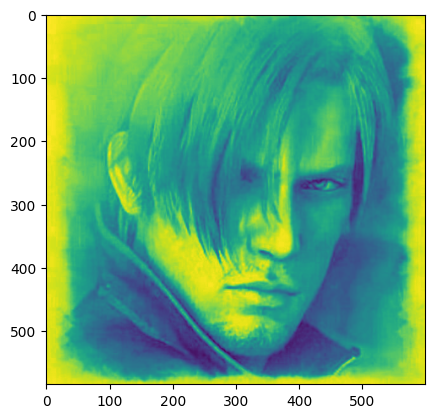

In [6]:
blade = Image.open(r"D:\GOD OF WAR 1\Telegram\Telegram Documents\Telegram Images\425728451_170223.jpg")
blade_1 = blade.convert("L")

people = Image.open(r"D:\GOD OF WAR 1\Telegram\Telegram Documents\Telegram Images\Leon_2.jpg")
people_1 = people.convert("L")
plt.imshow(blade_1)
plt.imshow(people_1)